In [1]:
#Import all the UTILITY functions
from UTILITY_quickstart import *

#Initialize tao object for single-particle tracking only
tao = initializeTao()

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-S2E
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using /Users/nmajik/Documents/SLAC/FACET2-S2E/setLattice_configs/defaults.yml
WARNING! No beam file is specified!
Number of macro particles defined by input file
Beam created, written to /Users/nmajik/Documents/SLAC/FACET2-S2E/beams/activeBeamFile.h5, and reinit to tao


In [2]:
# The golden lattice gives 50 cm betas at PENT
tao.ele_twiss("PENT")

{'mode_flip': False,
 'beta_a': 0.506512407159176,
 'alpha_a': 0.046567897269014,
 'gamma_a': 1.9785666745595,
 'phi_a': 73.0782631370213,
 'eta_a': -5.54002627203796e-06,
 'etap_a': -1.05997356796689e-05,
 'beta_b': 0.500061933419418,
 'alpha_b': -0.121510418864699,
 'gamma_b': 2.02927820350916,
 'phi_b': 60.5531345883619,
 'eta_b': -2.11805920050045e-18,
 'etap_b': -2.52222176160021e-18,
 'eta_x': -5.54002627203796e-06,
 'etap_x': -1.05997356796689e-05,
 'eta_y': -2.11784425998279e-18,
 'etap_y': -2.52067060637746e-18}

# Single change

In [3]:
# A very common need for a FACET experimenter is to adjust the optics of the final focus magnets
# For example, to change the waist beta to 25 cm while maintaining the z location at PENT

sol = finalFocusSolver(
    tao,
    ele = "PENT",
    s_offset = 0.0,
    targetBetaX = 0.25,
    targetBetaY = 0.25,
    verbose = True,
    returnVariablesOrNames = "names"
)

Optimization Results:
Optimal Parameters: [ -80.47473629  -89.59821455   89.12609853  135.46381096 -238.97263841
  136.16624181]
Objective Function Value at Optimal Parameters: 0.0004467126172006661
Number of Iterations: 779
Converged: False


In [4]:
# Apply the proposed solution
[ setQuadkG(tao, ele, sol[ele]) for ele in sol.keys() ] 

# Check the result
tao.ele_twiss("PENT")

{'mode_flip': False,
 'beta_a': 0.252640492152456,
 'alpha_a': 1.88544345724462e-05,
 'gamma_a': 3.95819368398016,
 'phi_a': 73.1103737458044,
 'eta_a': -4.03819297939145e-06,
 'etap_a': -1.52241196785902e-05,
 'beta_b': 0.249919744033223,
 'alpha_b': 2.75199075535359e-05,
 'gamma_b': 4.00128451085646,
 'phi_b': 60.6695600849909,
 'eta_b': 3.86309165529581e-18,
 'etap_b': 1.0772415006074e-18,
 'eta_x': -4.03819297939145e-06,
 'etap_x': -1.52241196785902e-05,
 'eta_y': 3.86330413309847e-18,
 'etap_y': 1.07927677014497e-18}

# Waist scan

In [9]:
# Often, it is necessary to scan the waist location to find the optimal plasma interaction
# Let's make an asymmetric waist, beta_x = 50 cm and beta_y = 25 cm, and then scan that waist around PENT in 10 cm steps

scanSteps = [ {"s_offset" : s_offset} for s_offset in np.arange( -0.5, 0.6, 0.1) ]

for row in scanSteps:

    sol = finalFocusSolver(
        tao,
        ele = "PENT",
        s_offset = row["s_offset"],
        targetBetaX = 0.5,
        targetBetaY = 0.25,
        returnVariablesOrNames = "names"
    )

    row["sol"] = sol

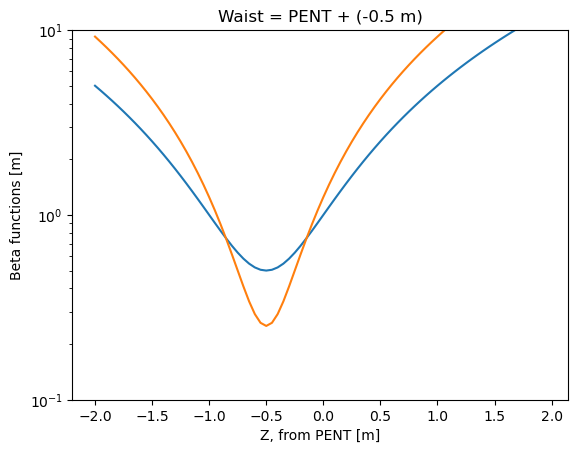

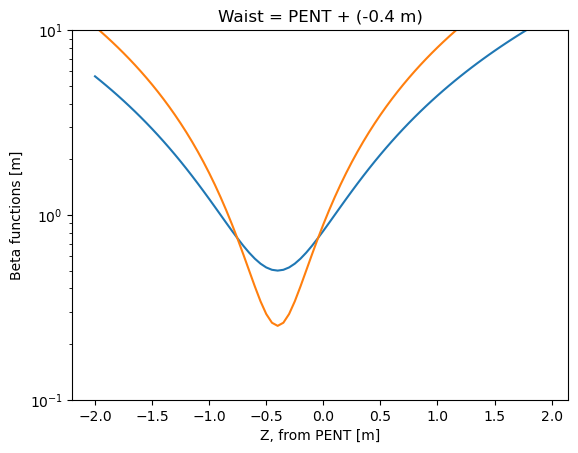

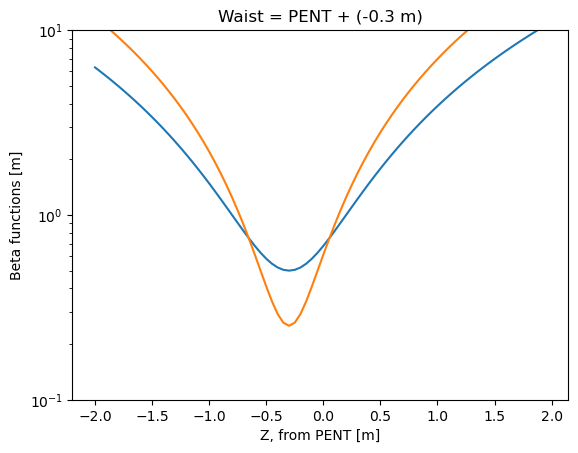

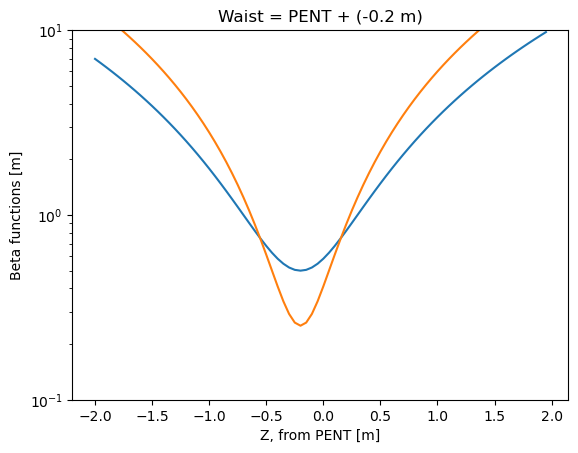

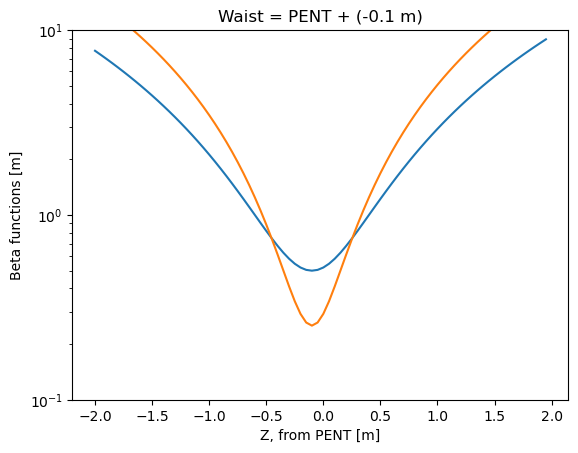

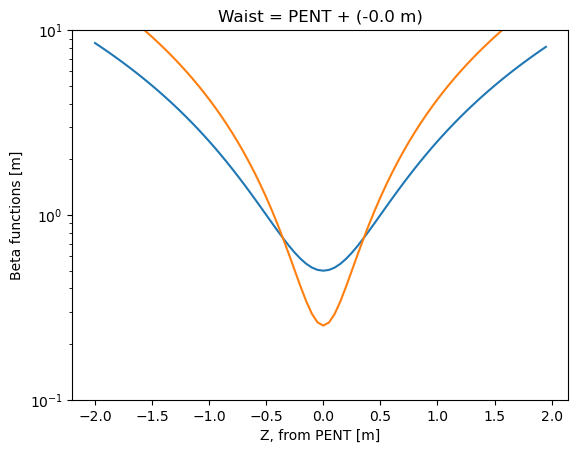

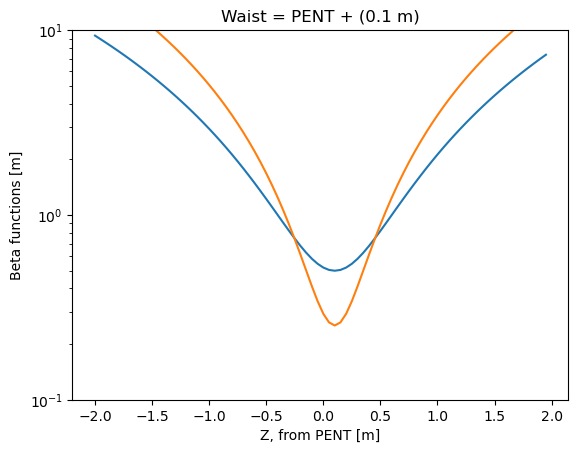

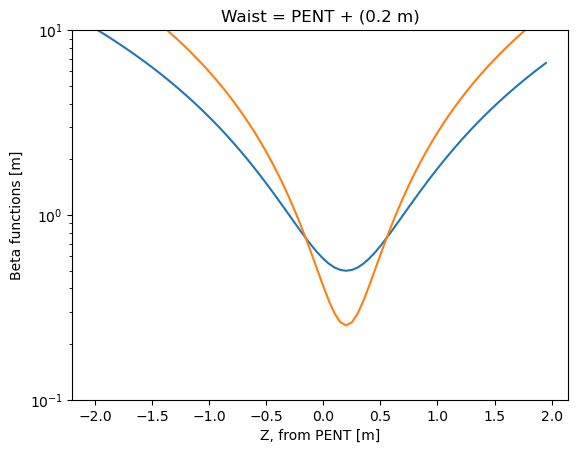

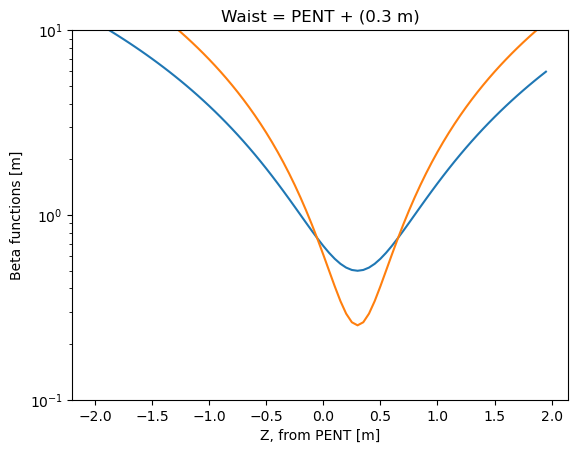

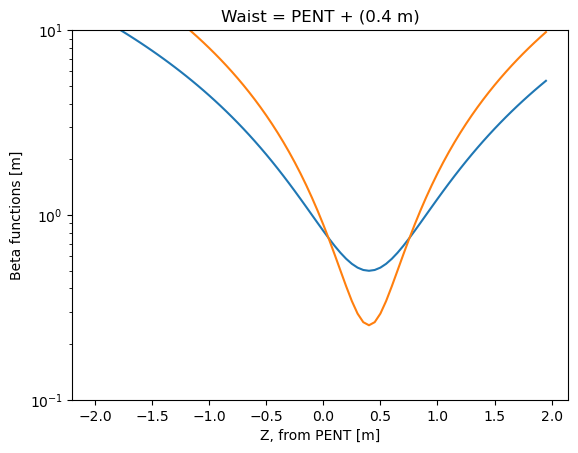

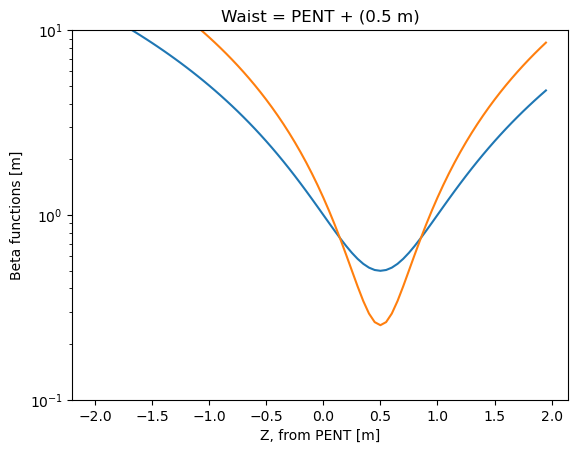

<Figure size 640x480 with 0 Axes>

In [22]:
# These results could then be fed directly into the EPICS control system to scan the magnets
# For this demo though, just plotting the results

def plotBetaFunctionsNearPENT(title = None):
    plotSOffsets = np.arange( -2, 2, 0.05 )
    xBetaFunctions = []
    yBetaFunctions = []
    for s_offset in plotSOffsets:
        twiss = tao.twiss_at_s( ele = "PENT", s_offset = s_offset )
    
        xBetaFunctions.append(twiss["beta_a"])
        yBetaFunctions.append(twiss["beta_b"])

    plt.plot(plotSOffsets, xBetaFunctions)
    plt.plot(plotSOffsets, yBetaFunctions)

    plt.yscale('log')
    plt.ylim( (0.1, 10) )
    
    plt.xlabel('Z, from PENT [m]')
    plt.ylabel('Beta functions [m]')
    if title:
        plt.title(title)
    
    plt.show()
    plt.clf()


for row in scanSteps:
    sol = row["sol"]
    
    # Apply the proposed solution
    [ setQuadkG(tao, ele, sol[ele]) for ele in sol.keys() ] 
    
    plotBetaFunctionsNearPENT( title = f"Waist = PENT + ({round(row["s_offset"], 2)} m)")


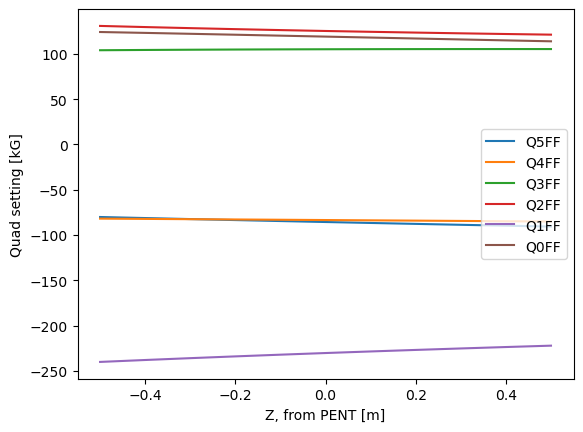

In [31]:
# And let's look at the magnet settings that give these results
plt.clf()

for key in sol.keys():
    plt.plot( 
        [ row["s_offset"] for row in scanSteps ],
        [ row["sol"][key] for row in scanSteps ]
    )
plt.legend(sol.keys(), loc = "right")
plt.xlabel('Z, from PENT [m]')
plt.ylabel('Quad setting [kG]')

plt.show()